In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

device(type='cpu')

In [17]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
img,label = next(iter(train_loader))
img.device

device(type='cpu')

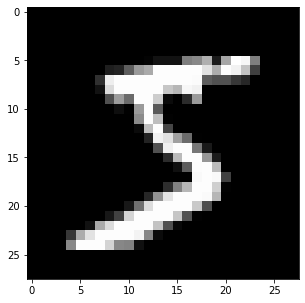

In [14]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Model

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding = 1)
        self.conv1a = nn.Conv2d(16, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
        
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)

        
    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1a(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
# print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             580
         MaxPool2d-5              [-1, 4, 7, 7]               0
   ConvTranspose2d-6           [-1, 16, 14, 14]             272
   ConvTranspose2d-7            [-1, 1, 28, 28]              65
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.01
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [33]:
if torch.has_cudnn:
    device = torch.device("cuda:{}".format('0'))
else:
    device = torch.device("cpu")
model = model.to(device)
# F: sets model in evaluation mode. It has an effect in certain modules: e.g. Dropout or BatchNorm Layers
# model.eval()

In [36]:
# from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
summary(model, input_size=(1, 28, 28), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             580
         MaxPool2d-5              [-1, 4, 7, 7]               0
   ConvTranspose2d-6           [-1, 16, 14, 14]             272
   ConvTranspose2d-7            [-1, 1, 28, 28]              65
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.01
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [ ]:
# # Example of using Sequential with OrderedDict
# model = nn.Sequential(OrderedDict([
#           ('conv1', nn.Conv2d(1,20,5)),
#           ('relu1', nn.ReLU()),
#           ('conv2', nn.Conv2d(20,64,5)),
#           ('relu2', nn.ReLU())
#         ]))


In [37]:
# loss function
criterion = nn.MSELoss()

# loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data[0].to(device), data[1]
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.139754
Epoch: 2 	Training Loss: 0.139578
Epoch: 3 	Training Loss: 0.139407
Epoch: 4 	Training Loss: 0.139253
Epoch: 5 	Training Loss: 0.139114


KeyboardInterrupt: 

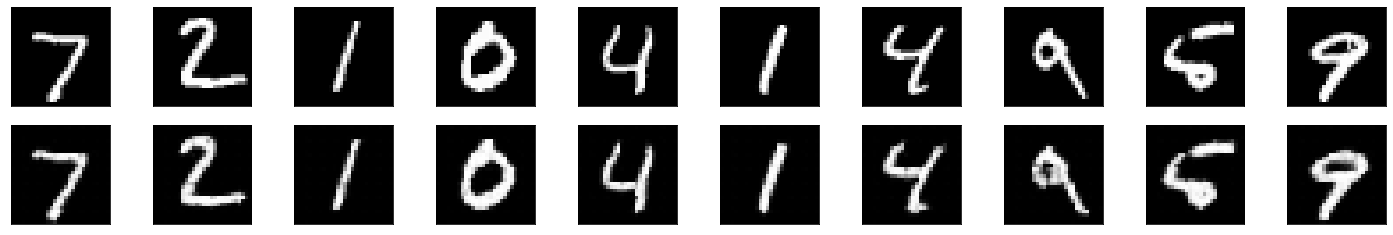

In [48]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device=device))
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)